# 2D simulations

3 methods for the 1 dimensional simulation:
1. Forward Euler method
2. Next Reaction Method
3. Runge-Kutta 4

Root tip will be on the left of the plots, root top on the right.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
%matplotlib notebook
import cv2
import re
import glob
import matplotlib as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


#### Color palette

In [62]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate([np.linspace(0,10/256,3*N//4),np.linspace(10/256,234/256, N//4)])[::-1]
vals[:, 1] = np.concatenate([np.linspace(43/256,120/256,3*N//4),np.linspace(120/256, 239/256, N//4)])[::-1]
vals[:, 2] = np.concatenate([np.linspace(138/256,166/256,3*N//4),np.linspace(166/256, 244/256, N//4)])[::-1]
grieneisen = ListedColormap(vals,name="grieneisen")

### Forward Euler

In [63]:
def update_grid_cells(cells, pins, D=0.3, T=0.2, decay_rate=0.000005, auxin_source=1000):
    
    """
    pins = [i,j,direction]
    direction index = [up,down,left,right]
    """
    
    d_cells = np.zeros(cells.shape)
    
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            value = cells[i,j]
            # check for spatial limits to evaluate diffusion 
            if i == 0 or i == cells.shape[0]-1:
                # first or last row of the grid
                if j == 0 or j == cells.shape[1]-1:
                    # top-left, top-right, bottom-left, bottom-right corner cells
                    if i == 0 and j == 0:
                        # top-left = D*(down_cell + right_cell - 2*self_cell) + T*(pins_up*down_cell + pins_left*right_cell 
                        #                                                          - pins_down*self_cell -pins_right*self_cell)
                        d_cells[i,j] = D*(cells[i+1,j] + cells[i,j+1] - 3*cells[i,j]) + T*(pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1] -cells[i,j]*(pins[i,j,1]+pins[i,j,3]))
                        flag = "topleft"
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                    if i == 0 and j == cells.shape[1]-1:
                        # top-right = D*(left_cell + down_cell - 2*self_cell) + T*(pins_right*left_cell + pins_up*down_cell
                        #                                                          - self_cell*(pins_left + pins_down))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] - 2*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,1]))
                        flag = "topright"
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                    if i == cells.shape[0]-1 and j == 0:
                        # bottom-left = D*(up_cell + right_cell - 2*self_cell) 
                        #               + T*(pins_left*rigth_cell + pins_down*up_cell
                        #                    - self_cell*(pins_right + pins_up))
                        d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] -2*cells[i,j]) + T*(pins[i,j+1,2]*cells[i,j+1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,3] + pins[i,j,0]))
                        flag = "bottomleft"
                    if i == cells.shape[0]-1 and j == cells.shape[1]-1:
                        # bottom-right = D*(left_cell + up_cell - 2*self_cell) 
                        #                + T*(auxin_source + pins_right*left_cell + pins_down*up_cell
                        #                     - self_cell*(pins_left + pins_up))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] - 2*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,0]))
                        flag = "bottomright"
                elif i == 0:
                    # non-corner cell on top row
                    # top-row-cell = D*(left_cell + down_cell + right cell - 3*self_cell) 
                    #                +T*(pins_right*left_cell + pins_up*down_cell + pins_left*right_cell
                    #                    - self_cell(pins_left + pins_down + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] + cells[i,j+1] - 4*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2]+pins[i,j,1]+pins[i,j,3]))
                    flag = "topnoncorner"
                    if 2 <= j <= 7:
                        # We assume they receive auxin from above in qty auxin_source
                        d_cells[i,j] += auxin_source
                    else:
                        # We assume they have another cell on top on which they discharge some auxin
                        # d_cells[i,j] -= D*(cells[i,j])+T*(cells[i,j])
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                else:
                    # non-corner cell on bottom row
                    # bottom-row-cell = D*(left_cell + up_cell + right cell - 3*self_cell)
                    #                   + T*(pins_right*left_cell + pins_down*up_cell + pins_left*right_cell
                    #                        - self_cell*(pins_left + pins_up + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] + cells[i,j+1] - 3*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2] + pins[i,j,0] + pins[i,j,3]))
                    flag = "bottomnoncorner"
            elif j == 0:
                # non-corner cases on leftmost column
                # left-row-cell = D*(up_cell + right_cell + down_cell - 3*self_cell) 
                #                 + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                      - self_cell*(pins_up + pins_right + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] + cells[i+1,j] - 3*cells[i,j])+T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1] + pins[i+1,j,0]*cells[i+1,j] - cells[i,j]*(pins[i,j,0]+pins[i,j,3]+pins[i,j,1]))
                flag = "leftnoncorner"
            elif j == cells.shape[1]-1:
                # non-corner cases on rightmost column
                # right-row-cell = D*(up_cell + left_cell + down_cell - 3*self_cell) 
                #                  + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                       - self_cell*(pins_up + pins_left + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j-1] + cells[i+1,j] - 3*cells[i,j])+ T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]- cells[i,j]*(pins[i,j,0]+pins[i,j,2]+pins[i,j,1]))
                flag = "rightnoncorner"
            else:
                # central-cell = D*(up_cell + down_cell + left_cell + right_cell - 4*self_cell) 
                #               + T*(pins_down*up_cell + pins_up*down_cell + pins_right*left_cell + pins_left*right_cell
                #                 - self_cell*(pins_up + pins_down + pins_left+ pins_right))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i+1,j] + cells[i,j-1] + cells[i,j+1] - 4*cells[i,j])+T*(pins[i-1,j,1]*cells[i-1,j] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,0]+pins[i,j,1]+pins[i,j,2]+pins[i,j,3]))
                flag = "central"
    
    # basal production
    #d_cells += 8*12*0.0005*4
    
    # basal decay
    #d_cells -= d_cells*decay_rate
    return d_cells


Define root

In [64]:
# Populate pins matrix with various cell types!

# up down left right
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [8,0,0,0], [8,0,0,0] 
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [0,8,0,12], [0,8,12,0]
vascular = [0,8,0,0]

# Set initial auxin concentrations
root = np.ones((20,10))
# root[0,5] = 10
pins = np.zeros((20,10,4))

# Locate the cells
pins[:-4,3:7,:] = vascular
pins[-4:,:,:] = colummella
pins[:-4,2,:] = border_l
pins[:-4,-3,:] = border_r
pins[:-4,:2,:] = epidermal_l
pins[:-4,-2:,:] = epidermal_r

Run the algorithm

<IPython.core.display.Javascript object>


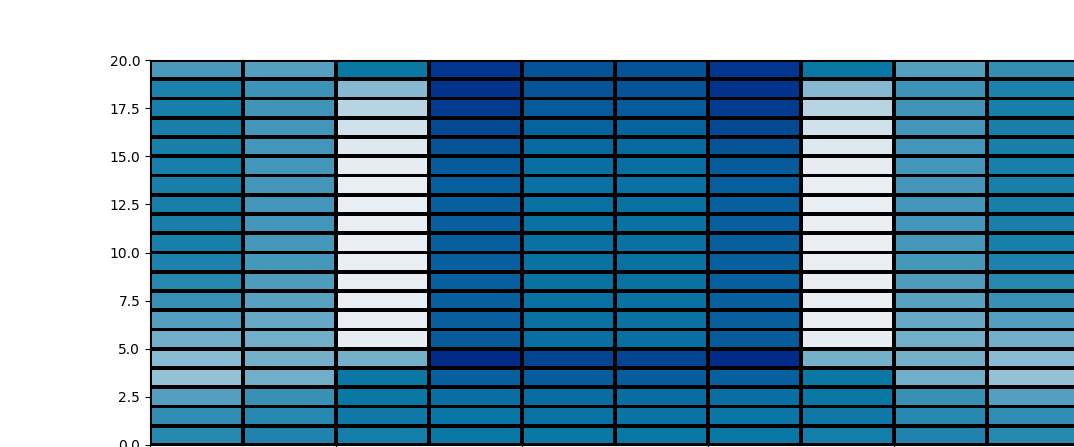

KeyboardInterrupt: 

In [65]:
%matplotlib notebook
fig= plt.figure(figsize=(6,12)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')

#sink = [10,10,.1,.1,.10,.10,.10,.1,10,10]

timeline = [root]
dt = 0.05
timerange = np.arange(0,60.05,dt)
for t in timerange:
    root_step = dt*update_grid_cells(root,pins,D=0.5,T=0.5, auxin_source=10)
    root = np.add(root, root_step)
    timeline.append(root)
    plt.pcolormesh(root[::-1,:], cmap = grieneisen, edgecolor='k', linewidth=2)
    plt.colorbar()
    plt.title(f"Seconds: {str(round(t,1))}")
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t < timerange[-1]:
        plt.clf()
        
    #plt.savefig(f"root_2D_FE/2D_root:{str(T[-1])}.png")

Create video

In [90]:
# create video of all images
img_test = cv2.imread("root_2D_FE/2D_root:0.0.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_2D_FE/2D_FE.avi',fourcc, 20.0, (width, height))

for t in np.arange(0,20,0.01):  
    img = cv2.imread(f"root_2D_FE/2D_root:{str(t)}.png")
    out.write(img)
    
cv2.destroyAllWindows()
out.release()

Grid search for T and D

<IPython.core.display.Javascript object>


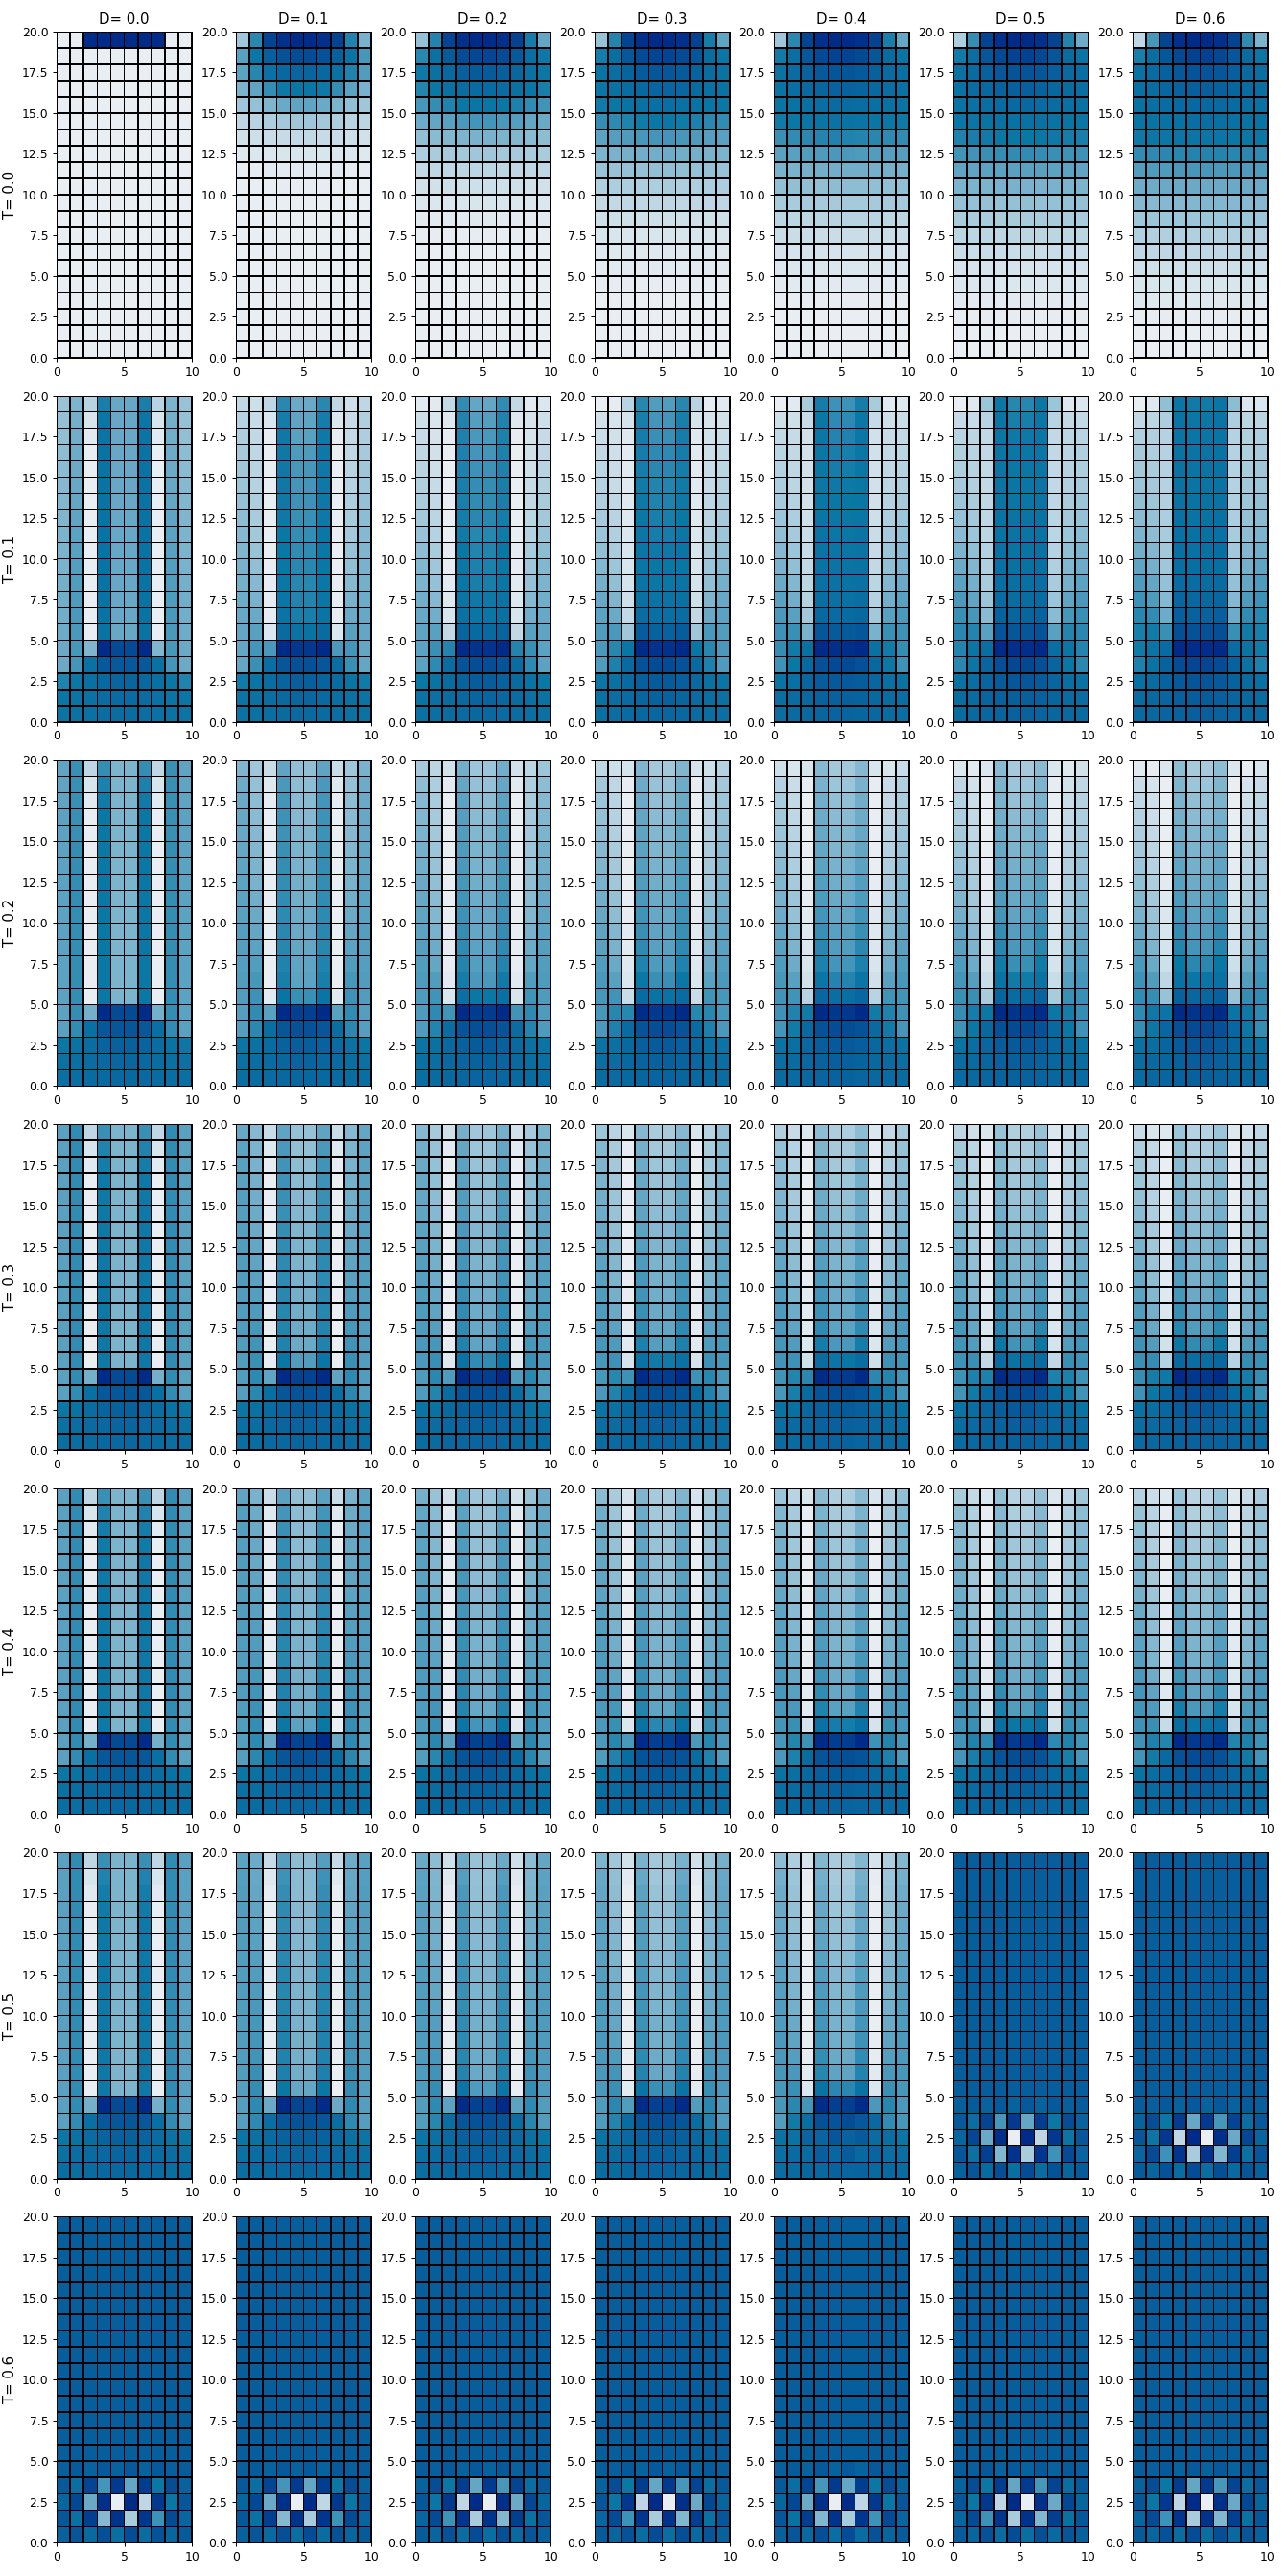

round: 1
round: 2
round: 3
round: 4
round: 5
round: 6
round: 7
round: 8
round: 9
round: 10
round: 11
round: 12
round: 13
round: 14
round: 15
round: 16
round: 17
round: 18
round: 19
round: 20
round: 21
round: 22
round: 23
round: 24
round: 25
round: 26
round: 27
round: 28
round: 29
round: 30
round: 31
round: 32
round: 33
round: 34
round: 35
round: 36
round: 37
round: 38
round: 39
round: 40
round: 41
round: 42
round: 43
round: 44
round: 45
round: 46
round: 47
round: 48
round: 49


In [81]:
T_values=[t for t in np.arange(0,0.7, 0.1)]
D_values=[d for d in np.arange(0,0.7, 0.1)]

timeline = [root]
dt = 0.05
timerange = np.arange(0,60.05,dt)    #60.05

fig, axs = plt.subplots(len(T_values), len(D_values), figsize=(15, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =1.5, wspace=0.5)
axs = axs.ravel()

for i in range(len(T_values)):
    for j in range(len(D_values)):
        root = np.ones((20,10))
        for t in timerange:
            plot_location=i*(len(T_values))+j
            root_step = dt*update_grid_cells(root,pins,D=D_values[j],T=T_values[i], auxin_source=10)
            root = np.add(root, root_step)
            timeline.append(root)
            if t==timerange[-1]:
                axs[plot_location].pcolormesh(root[::-1,:], cmap = grieneisen, edgecolor='k', linewidth=0.5)                

#Adding lables for columns and rows        
cols=['D= {}'.format(round(col,2)) for col in D_values]
rows=['T= {}'.format(round(row,2)) for row in T_values]

for ax, col in zip(axs, cols):
        ax.set_title(col)

axs_r=axs[0::7]    
for ax, row in zip(axs_r, rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.savefig('grid_seach_parameters.png')
plt.show()

### Next Reaction Method
Uses same update function as FE

Again, define the root


In [81]:
# Populate pins matrix with various cell types!

# up down left right
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [8,0,0,0], [8,0,0,0] 
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [0,8,0,12], [0,8,12,0]
vascular = [0,8,0,0]

# Set initial auxin concentrations
root = np.ones((20,10))
# root[0,5] = 10
pins = np.zeros((20,10,4))

# Locate the cells
pins[:-4,3:7,:] = vascular
pins[-4:,:,:] = colummella
pins[:-4,2,:] = border_l
pins[:-4,-3,:] = border_r
pins[:-4,:2,:] = epidermal_l
pins[:-4,-2:,:] = epidermal_r

Run the algorithm

<IPython.core.display.Javascript object>


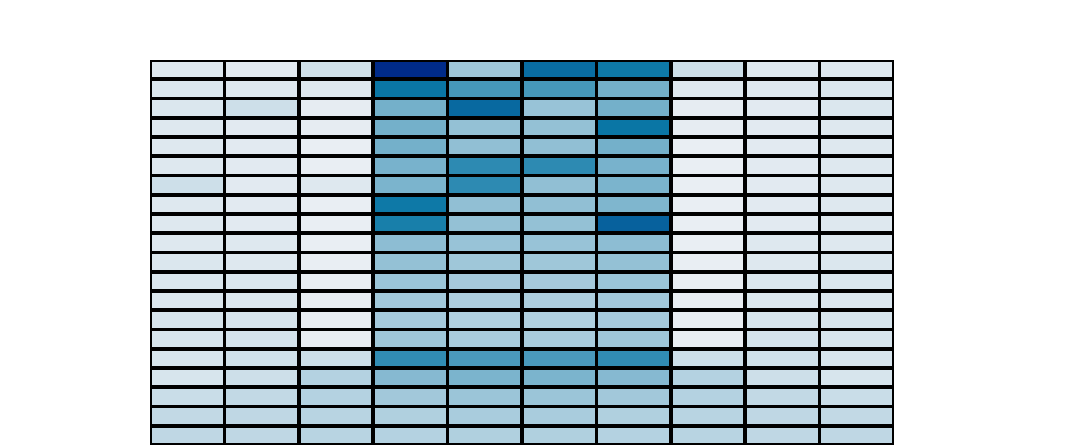

KeyboardInterrupt: 

In [100]:
cells_out=root

fig=plt.figure(figsize=(6,12)) 
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_out, cmap = grieneisen)

T = []
t = 0
sim_time=1
while t<sim_time:
    cells_prev = cells_out    #need to keep track of the previous state
    cells_step = update_grid_cells(cells_out, pins, D=0.04, T=0.5, auxin_source=1)
    #cells_out = np.add(cells_out, cells_step)
    
    z1 = np.random.uniform(0,1)
    acum = np.cumsum(cells_out)
    atot = acum[-1] 
    tau = -np.log(z1)/np.sum(cells_out) 
    if tau<0.01:
        tau=0.01
    z2 = np.random.uniform(0,1)
    zatot = z2*atot
    mu = np.where(acum>zatot)[0][0]
    cells_prev[mu//20][mu%10] = cells_prev[mu//20][mu%10] + cells_out[mu//20][mu%10]    #only one cell will be updated
    cells_out=cells_prev
    t = t + tau
    T.append(t)
    
    plt.pcolormesh(cells_out[::-1,:], cmap = grieneisen, edgecolor='k', linewidth=2)
    plt.colorbar()
    plt.title(f"Seconds: {str(T[-1])}")
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t < sim_time:
        plt.clf()
    
    #plt.savefig(f"root_2D_NRM/2D_root:{str(T[-1])}.png")

Create video

In [86]:
# create video of all images
# first, need to sort the images in the correct way
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]


img_test = cv2.imread(f"root_2D_NRM/2D_root:{str(T[-1])}.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_2D_NRM/2D_NRM.avi',fourcc, 20.0, (width, height))

images=glob.glob("root_2D_NRM/*.png")
images.sort(key=natural_keys)

for image in images:
    img = cv2.imread(image)
    out.write(img)
    
cv2.destroyAllWindows()
out.release()

### Runge-Kutta 4

Modified algorithm: has t as input

In [83]:
def update_grid_cells_rk(t, cells, pins, D=0.3, T=0.2, decay_rate=0.000005, auxin_source=1000):
    
    """
    pins = [i,j,direction]
    direction index = [up,down,left,right]
    """
    
    d_cells = np.zeros(cells.shape)
    
    for i in range(cells.shape[0]):
        for j in range(cells.shape[1]):
            value = cells[i,j]
            # check for spatial limits to evaluate diffusion 
            if i == 0 or i == cells.shape[0]-1:
                # first or last row of the grid
                if j == 0 or j == cells.shape[1]-1:
                    # top-left, top-right, bottom-left, bottom-right corner cells
                    if i == 0 and j == 0:
                        # top-left = D*(down_cell + right_cell - 2*self_cell) + T*(pins_up*down_cell + pins_left*right_cell 
                        #                                                          - pins_down*self_cell -pins_right*self_cell)
                        d_cells[i,j] = D*(cells[i+1,j] + cells[i,j+1] - 3*cells[i,j]) + T*(pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1] -cells[i,j]*(pins[i,j,1]+pins[i,j,3]))
                        flag = "topleft"
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                    if i == 0 and j == cells.shape[1]-1:
                        # top-right = D*(left_cell + down_cell - 2*self_cell) + T*(pins_right*left_cell + pins_up*down_cell
                        #                                                          - self_cell*(pins_left + pins_down))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] - 2*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,1]))
                        flag = "topright"
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                    if i == cells.shape[0]-1 and j == 0:
                        # bottom-left = D*(up_cell + right_cell - 2*self_cell) 
                        #               + T*(pins_left*rigth_cell + pins_down*up_cell
                        #                    - self_cell*(pins_right + pins_up))
                        d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] -2*cells[i,j]) + T*(pins[i,j+1,2]*cells[i,j+1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,3] + pins[i,j,0]))
                        flag = "bottomleft"
                    if i == cells.shape[0]-1 and j == cells.shape[1]-1:
                        # bottom-right = D*(left_cell + up_cell - 2*self_cell) 
                        #                + T*(auxin_source + pins_right*left_cell + pins_down*up_cell
                        #                     - self_cell*(pins_left + pins_up))
                        d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] - 2*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j]-cells[i,j]*(pins[i,j,2] + pins[i,j,0]))
                        flag = "bottomright"
                elif i == 0:
                    # non-corner cell on top row
                    # top-row-cell = D*(left_cell + down_cell + right cell - 3*self_cell) 
                    #                +T*(pins_right*left_cell + pins_up*down_cell + pins_left*right_cell
                    #                    - self_cell(pins_left + pins_down + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i+1,j] + cells[i,j+1] - 4*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2]+pins[i,j,1]+pins[i,j,3]))
                    flag = "topnoncorner"
                    if 2 <= j <= 7:
                        # We assume they receive auxin from above in qty auxin_source
                        d_cells[i,j] += auxin_source
                    else:
                        # We assume they have another cell on top on which they discharge some auxin
                        # d_cells[i,j] -= D*(cells[i,j])+T*(cells[i,j])
                        d_cells[i,j] = d_cells[i,j] - (T*8*cells[i,j] + D*cells[i,j])
                else:
                    # non-corner cell on bottom row
                    # bottom-row-cell = D*(left_cell + up_cell + right cell - 3*self_cell)
                    #                   + T*(pins_right*left_cell + pins_down*up_cell + pins_left*right_cell
                    #                        - self_cell*(pins_left + pins_up + pins_right))
                    d_cells[i,j] = D*(cells[i,j-1] + cells[i-1,j] + cells[i,j+1] - 3*cells[i,j]) + T*(pins[i,j-1,3]*cells[i,j-1] + pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,2] + pins[i,j,0] + pins[i,j,3]))
                    flag = "bottomnoncorner"
            elif j == 0:
                # non-corner cases on leftmost column
                # left-row-cell = D*(up_cell + right_cell + down_cell - 3*self_cell) 
                #                 + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                      - self_cell*(pins_up + pins_right + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j+1] + cells[i+1,j] - 3*cells[i,j])+T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j+1,2]*cells[i,j+1] + pins[i+1,j,0]*cells[i+1,j] - cells[i,j]*(pins[i,j,0]+pins[i,j,3]+pins[i,j,1]))
                flag = "leftnoncorner"
            elif j == cells.shape[1]-1:
                # non-corner cases on rightmost column
                # right-row-cell = D*(up_cell + left_cell + down_cell - 3*self_cell) 
                #                  + T*(pins_down*up_cell + pins_left*right_cell + pins_up*down_cell
                #                       - self_cell*(pins_up + pins_left + pins_down))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i,j-1] + cells[i+1,j] - 3*cells[i,j])+ T*(pins[i-1,j,1]*cells[i-1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i+1,j,0]*cells[i+1,j]- cells[i,j]*(pins[i,j,0]+pins[i,j,2]+pins[i,j,1]))
                flag = "rightnoncorner"
            else:
                # central-cell = D*(up_cell + down_cell + left_cell + right_cell - 4*self_cell) 
                #               + T*(pins_down*up_cell + pins_up*down_cell + pins_right*left_cell + pins_left*right_cell
                #                 - self_cell*(pins_up + pins_down + pins_left+ pins_right))
                d_cells[i,j] = D*(cells[i-1,j] + cells[i+1,j] + cells[i,j-1] + cells[i,j+1] - 4*cells[i,j])+T*(pins[i-1,j,1]*cells[i-1,j] + pins[i+1,j,0]*cells[i+1,j] + pins[i,j-1,3]*cells[i,j-1] + pins[i,j+1,2]*cells[i,j+1]- cells[i,j]*(pins[i,j,0]+pins[i,j,1]+pins[i,j,2]+pins[i,j,3]))
                flag = "central"
    
    # basal production
    #d_cells += 8*12*0.0005*4
    
    # basal decay
    #d_cells -= d_cells*decay_rate
    return d_cells

# Actual RK
def RK4(f):
    return lambda t, y, dt: (
            lambda dy1: (
            lambda dy2: (
            lambda dy3: (
            lambda dy4: (dy1 + 2*dy2 + 2*dy3 + dy4)/6
            )( dt * f( t + dt  , y + dy3, pins   ) )
        )( dt * f( t + dt/2, y + dy2/2, pins ) )
        )( dt * f( t + dt/2, y + dy1/2, pins ) )
        )( dt * f( t       , y         ,pins) )

Define root

In [84]:
# Populate pins matrix with various cell types!

# up down left right
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [8,0,0,0], [8,0,0,0] 
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [0,8,0,12], [0,8,12,0]
vascular = [0,8,0,0]

# Set initial auxin concentrations
root = np.ones((20,10))
# root[0,5] = 10
pins = np.zeros((20,10,4))

# Locate the cells
pins[:-4,3:7,:] = vascular
pins[-4:,:,:] = colummella
pins[:-4,2,:] = border_l
pins[:-4,-3,:] = border_r
pins[:-4,:2,:] = epidermal_l
pins[:-4,-2:,:] = epidermal_r

<IPython.core.display.Javascript object>


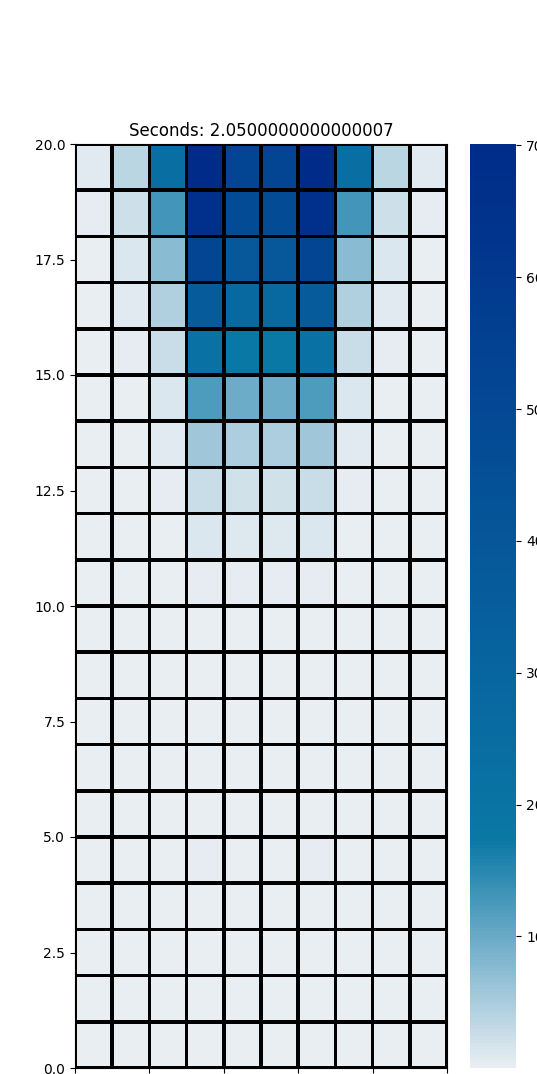

KeyboardInterrupt: 

In [89]:
%matplotlib notebook

fig=plt.figure(figsize=(6,12)) 
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(root, cmap = grieneisen)

root = np.ones((20,10))

t, y, dt = 0.0, root, 0.05
dy = RK4(update_grid_cells_rk)

while t <= 5:
    if abs(round(t) - t) < 1:
        t, y = t + dt, y + dy( t, y, dt )
        
        y.shape=(20,10)
        
        plt.pcolormesh(y[::-1,:], cmap = grieneisen, edgecolor='k', linewidth=2)
        plt.colorbar()
        plt.title(f"Seconds: {str(t)}")
        fig.canvas.draw()
        fig.canvas.flush_events()
        if t < timerange[-1]:
            plt.clf()
        
        plt.savefig(f"root_2D_RK/2D_root:{str(t)}.png")

Create the video

In [88]:
#First, need to sort the images in the correct way
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]


img_test = cv2.imread(f"root_2D_RK/2D_root:{str(t)}.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_2D_RK/2D_RK.avi',fourcc, 20.0, (width, height))

images=glob.glob("root_2D_RK/*.png")
images.sort(key=natural_keys)
for image in images:
    img = cv2.imread(image)
    out.write(img)
    
cv2.destroyAllWindows()
out.release()